# Import Libraries

In [148]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import random
import gpytorch
from tqdm import trange
from gpytorch.likelihoods import GaussianLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.objective import GenericMCObjective

# Set Up the Standardizer and Normalizer for the Tensors

In [149]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

# Load the needed dataset 

In [150]:
torch.set_default_dtype(torch.float64)

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")

# Make the plot resolutions higher
plt.rcParams['figure.dpi'] = 300

dataset = 'Perovskite'
data = pd.read_csv(f"datasets/{dataset}_dataset.csv")
# merge rows that have the same values 
data = data.groupby(list(data.columns[:-1])).mean()
data = pd.DataFrame(data.reset_index())

# create tensors of the input and output data
X_ = torch.tensor(data.iloc[:, :-1].values)
y_ = torch.tensor(data.iloc[:, -1].values)

# We are using prededfined candidates, so we can scale at the start
TorchStd = TorchStandardScaler()
TorchStd.fit(X_)

# set the seed for all random use
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)



CUDA device found, setting as device.


# Initialize the surrogate model, kernel, and acquisition function

In [151]:
# initialize the model 
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(GPModel, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# create an upper confidence bound acquisition function
def UCB(pred, epsilon=2):
    return pred.mean + epsilon*pred.stddev

# Optimize the model using BO 

In [152]:
optimizationCycles = 100
initialExp = 10


# set the seeds for reproducibility
set_seeds(42)

n = len(data)
idxs = torch.randperm(n)[:initialExp]

X = X_.clone()[idxs]
y = y_.clone()[idxs]



# optimize the model
for i in trange(optimizationCycles):

    # standardize the initial inputs and outputs before
    torch_std = TorchStandardScaler()
    X = torch_std.fit_transform(X)
    y_scaler = TorchStandardScaler()
    y = y_scaler.fit_transform(y).flatten()  # Ensure y is 1-dimensional

    bestY = y.max().item()

    # optimize the model
    # use a half normal prior for the noise to find a Gaussian likelihood
    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

    # using the found likelihood, create a GP model
    gp = GPModel(X, y, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    # fit the model by maximizing the marginal log likelihood
    gp.train()
    likelihood.train()
    fit_gpytorch_mll(mll)

    gp.eval()
    likelihood.eval()

    # predict from candidate pool
    with torch.no_grad():
        pred = gp(TorchStd.transform(X_)) # predict values for all candidates

    # pass the predictions through an acquisition function to find the next best point to sample
    acqVal = UCB(pred)
    acqVal[idxs] = -float('inf')  # Don't select already sampled points
    idxs = torch.cat([idxs, acqVal.argmax().unsqueeze(0)]) # add best value to index

    # add the new point to the training data
    X = X_[idxs]
    y = y_[idxs]
    



100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


# Plot the Results

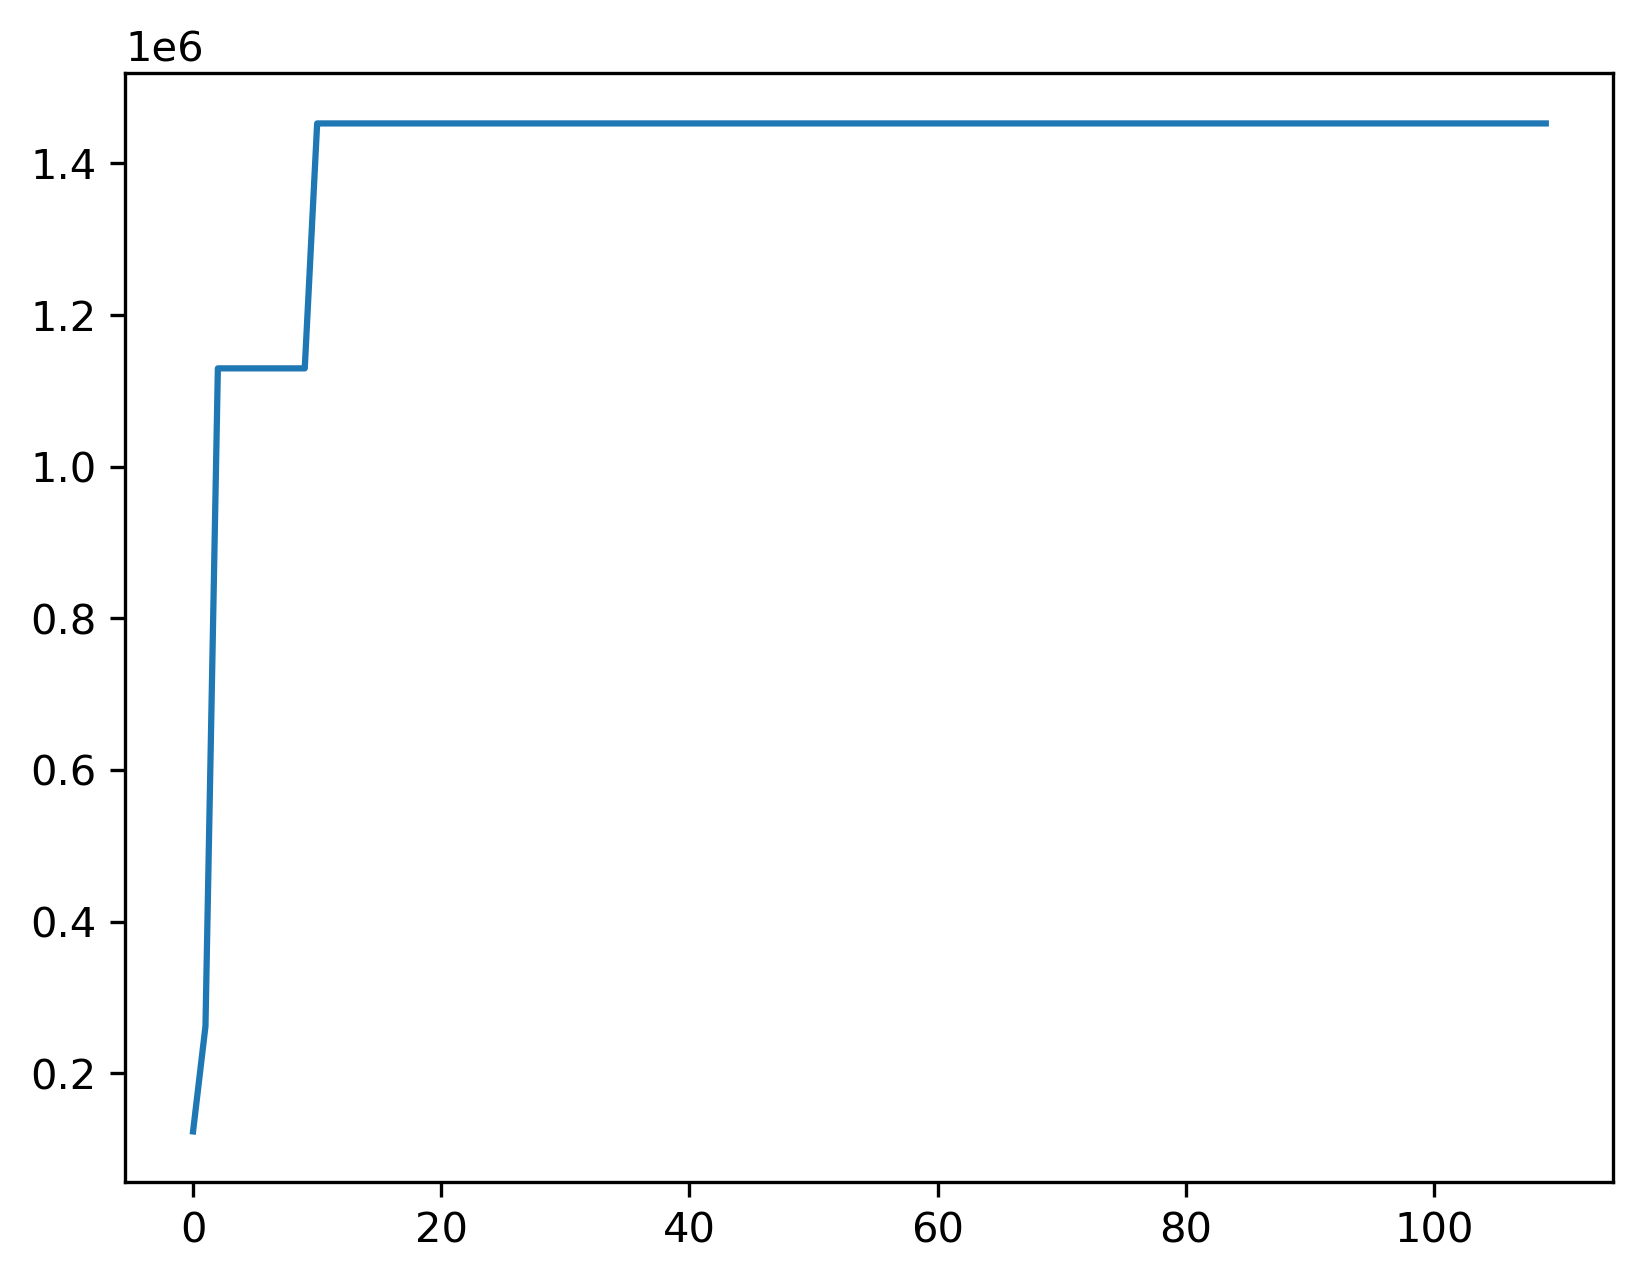

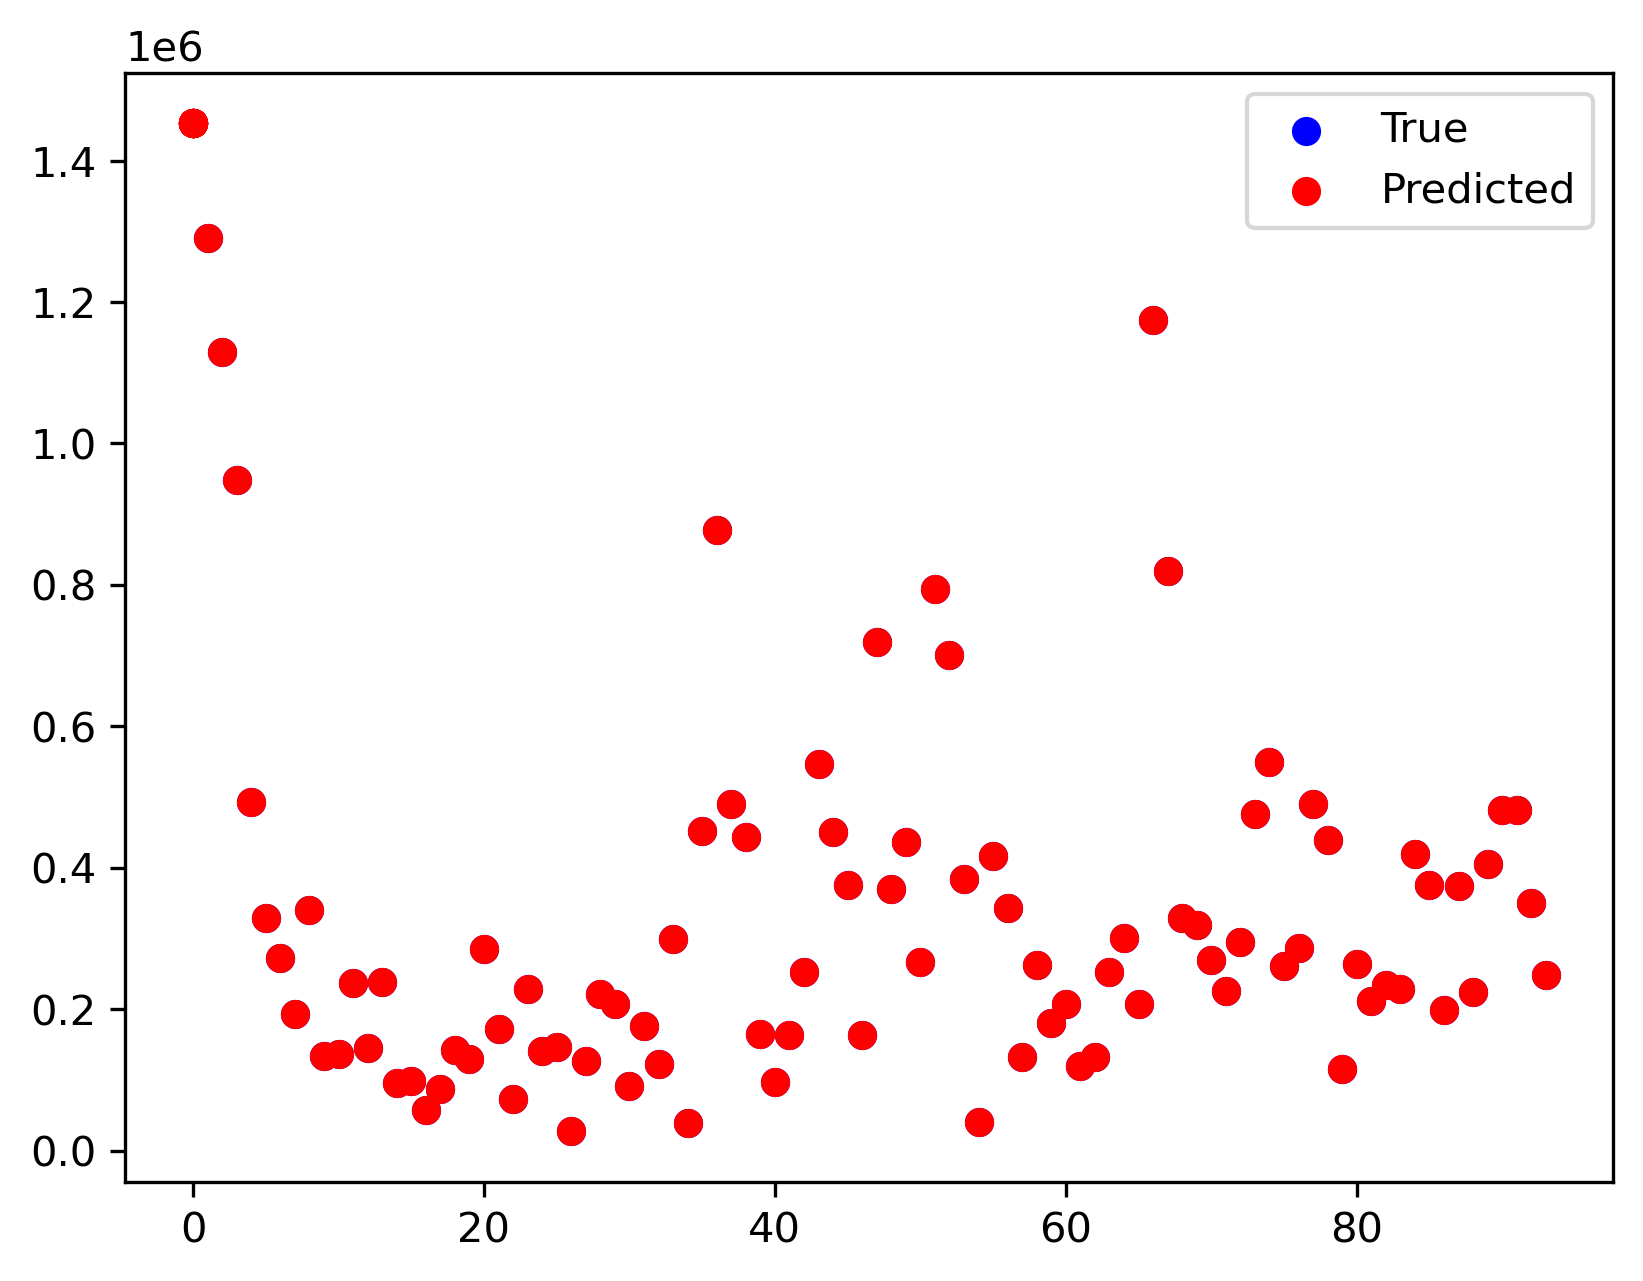

In [153]:
plt.plot(np.maximum.accumulate(y.detach().numpy()), label='True')
plt.show()

# find the indexes of the values that were found from the y_ 


# plot the values found over the initial dataset as a new scatter plot. The x axis should be the index and the y axis should be the value of the output data
plt.scatter(range(len(y_)), y_.detach().numpy(), label='True', color='blue')
plt.scatter(idxs.detach().numpy(), y.detach().numpy(), label='Predicted', color='red')

plt.legend()
plt.show()
